In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!nvidia-smi

Fri Apr 12 18:35:08 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0              25W / 250W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
!pip install pytorch-warmup

In [4]:
import math, torch, torchaudio
import soundfile
import re
import torch.nn as nn
import torch.nn.functional as F
import os, numpy
from sklearn import metrics
from operator import itemgetter
import glob, numpy, os, random, soundfile, torch
from scipy import signal
import time
import tqdm
import pytorch_warmup as warmup
from torch.utils.tensorboard import SummaryWriter

2024-04-12 18:35:31.957793: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-12 18:35:31.957904: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-12 18:35:32.090540: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**Cloning the repository**

In [5]:
# Clone the repository
!git clone https://github.com/m23csa007/IndicSUPERB.git

Cloning into 'IndicSUPERB'...
remote: Enumerating objects: 606, done.
remote: Counting objects: 100% (606/606), done.
remote: Compressing objects: 100% (445/445), done.
remote: Total 606 (delta 147), reused 601 (delta 145), pack-reused 0
Receiving objects: 100% (606/606), 4.37 MiB | 20.24 MiB/s, done.
Resolving deltas: 100% (147/147), done.


**Data Preprocessing**

In [6]:
!python /kaggle/working/IndicSUPERB/utilities/structure.py \
  /kaggle/input/kathbath-dataset-test-known/kb_data_clean_m4a \
  /kaggle/working/kb_data_clean_wav \
  malayalam

Copying Transcripts
0it [00:00, ?it/s]
100%|███████████████████████████████████████| 1767/1767 [02:33<00:00, 11.54it/s]


**Dataset**


In [7]:
import pandas as pd

# Define the file path
file_path = '/kaggle/input/kathbath-metadata/meta_data/malayalam/test_known_data.txt'
#file_path = "/kaggle/input/kathbath-metadata/meta_data/hindi/test_known_data.txt"

# Read the text file into a DataFrame
df = pd.read_csv(file_path, delimiter='\t', header=None, names=['Index', 'Audio1', 'Audio2'])

# Print the size of the DataFrame
print("DataFrame size:", df.shape)


DataFrame size: (50000, 3)


In [8]:
import os
import random
import numpy
import soundfile
import torch

class KathbathDataset(object):
    def __init__(self, train_list, train_path, num_frames=300, **kwargs):
        self.train_path = train_path
        self.train_list = train_list
        self.num_frames = num_frames
        self.data_list = []
        self.data_label = []
#         print(self.train_list)
#         print(self.train_path)
        lines = open(self.train_list).read().splitlines()
        #print("lines", lines[0])
        dictkeys = list(set([x.split()[0] for x in lines]))
        #print("dictkeys",dictkeys)
        dictkeys.sort()
        self.dictkeys = {key: ii for ii, key in enumerate(dictkeys)}
        #print("dictkeys",self.dictkeys)
        i = 0
        for line in lines:
            speaker_label = self.dictkeys[line.split()[0]]
            file_names = line.split()[1:]
            #print("file_names", file_names)
            #file_paths = [os.path.join(train_path, file_name) for file_name in file_names]
            pair_file_path = []
            for file_name in file_names:
                base_name = os.path.basename(file_name)
                folder_path = file_name.split('/')
                full_file_path = os.path.join(train_path, folder_path[-2], base_name)
                pair_file_path.append(full_file_path)  # Append both file paths
                
            self.data_list.append(pair_file_path)
            self.data_label.append(speaker_label)  # Append the label once

#                 folder_path = os.path.dirname(file_name)
#                 file_paths.append(full_file_path)

#                 if i < 3: 
# #                     print("file_path", full_file_path)
#                     print("folder_path", folder_path)
#                     i += 1
#                 self.data_label.append(speaker_label)
#                 self.data_list.append(full_file_path)
                
#             if i < 4: 
#                     print("self.data_list", self.data_list)
#                     print("self.data_label", self.data_label)
#                     i += 1
                    
        #print(self.data_list)

    def __getitem__(self, index):
#         print("Hello")
#         print(self.data_list[index][0])
        try: 
            audio_data = []  # Initialize an empty list to store audio segments
            for file_name in self.data_list[index]:
                audio_segment, _ = soundfile.read(file_name)
                length = self.num_frames * 160 + 240
                if len(audio_segment) <= length:
                    shortage = length - len(audio_segment)
                    audio_segment = numpy.pad(audio_segment, (0, shortage), 'wrap')
                start_frame = numpy.int64(random.random() * (len(audio_segment) - length))
                audio_segment = audio_segment[start_frame:start_frame + length]
                audio_data.append(audio_segment)  # Append the audio segment to the list

            # Stack the audio segments along a new dimension to create concatenated audio
            concatenated_audio = numpy.stack(audio_data, axis=0).astype(numpy.float32)
            return torch.tensor(concatenated_audio), self.data_label[index]


        except Exception as e:
            length = self.num_frames * 160 + 240
            return torch.zeros((2, length)), self.data_label[index]

    def __len__(self):
        return len(self.data_list)


In [9]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import roc_curve

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [18]:
from torch.utils.data import DataLoader, random_split

# Define the dataset
train_dataset =  KathbathDataset("/kaggle/input/kathbath-metadata/meta_data/malayalam/test_known_data.txt", "/kaggle/working/kb_data_clean_wav/malayalam/test_known/audio", 300)


# Define the sizes of the training and validation sets
total_size = len(train_dataset)
train_size = int(0.8 * total_size)  # 80% for training
val_size = total_size - train_size

# Split the dataset into training and validation sets
train_data, val_data = random_split(train_dataset, [train_size, val_size])

# Define the sizes of the training and testing sets
total_size_test = len(train_data)
train_size_test = int(0.90 * total_size_test)  # 99% for training
test_size = total_size_test - train_size_test

# Split the dataset into training and testing sets
train_data_test, test_data = random_split(train_data, [train_size_test, test_size])

# Define the data loaders for training, validation, and testing
trainLoader = DataLoader(train_data, batch_size=8, shuffle=True, num_workers=10)
valLoader = DataLoader(val_data, batch_size=8, shuffle=False, num_workers=10)
testLoader = DataLoader(test_data, batch_size=8, shuffle=False, num_workers=10)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [19]:
print(len(trainLoader))
print(len(valLoader))
print(len(testLoader))

5000
1250
500


In [20]:
train_list = "/kaggle/input/kathbath-metadata/meta_data/malayalam/test_known_data.txt"
train_path = "/kaggle/working/kb_data_clean_wav/malayalam/test_known/audio"

In [21]:
iteration_count = 0
for batch in testLoader:
    inputs = batch[0]  # Assuming inputs are at index 0
    target = batch[1]  # Assuming targets are at index 1
    if inputs is None or target is None:
        continue
    # Your code here

   
    print("Iteration:", iteration_count)
    iteration_count += 1
    # Your remaining code here

    print("inputs:", inputs)
    print("Target:", target)
    
    if iteration_count == 10:
        break
    
# Input: tensor([ 0.0028,  0.0027,  0.0027,  ..., -0.0038, -0.0066, -0.0106])
# Input shape: torch.Size([48240])
# Target: 1

Iteration: 0
inputs: tensor([[[-4.6387e-03, -3.7537e-03, -3.6926e-03,  ...,  3.1525e-02,
          -2.3193e-02,  1.7242e-02],
         [ 2.8992e-03,  2.9297e-03,  1.0101e-02,  ..., -1.4038e-03,
          -1.1902e-03, -1.5259e-03]],

        [[-7.9956e-03, -6.5002e-03, -5.3711e-03,  ..., -1.1551e-01,
          -1.3098e-01, -1.3739e-01],
         [-1.2506e-01, -1.5857e-01, -1.5860e-01,  ...,  2.2882e-01,
           2.3907e-01,  2.3376e-01]],

        [[-3.3691e-02, -6.8024e-02, -5.2185e-03,  ...,  7.4463e-02,
           4.5868e-02,  2.2430e-02],
         [-1.5106e-02, -1.5320e-02, -9.0332e-03,  ...,  5.9204e-03,
           5.1880e-03,  2.5330e-03]],

        ...,

        [[-9.1553e-05, -9.1553e-05, -1.2207e-04,  ..., -6.7139e-04,
           1.6479e-03, -3.8147e-03],
         [-1.4038e-03, -2.4109e-03, -2.2888e-03,  ..., -4.1229e-02,
          -4.5288e-02, -4.9622e-02]],

        [[ 7.7209e-02,  6.4484e-02,  5.0018e-02,  ...,  6.1035e-05,
          -6.1035e-05, -1.2207e-04],
         [-8

In [14]:

# Check if CUDA is available
if torch.cuda.is_available():
    # Define the device as the first CUDA device
    device = torch.device("cuda:0")
    print("CUDA is available. Using GPU.")
else:
    # If CUDA is not available, use CPU
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")


CUDA is available. Using GPU.


**Import the model**

In [15]:
import torch
import numpy as np
from sklearn.metrics import roc_curve

from transformers import Wav2Vec2FeatureExtractor, WavLMForXVector

feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained('microsoft/wavlm-base-sv')
model = WavLMForXVector.from_pretrained('microsoft/wavlm-base-sv')


# Move model and feature extractor to CUDA if available
model.to(device)

# Save the pre-trained model to the specified directory
#model.save_pretrained(pretrained_model_directory)


preprocessor_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/58.6k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/405M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of the model checkpoint at microsoft/wavlm-base-sv were not used when initializing WavLMForXVector: ['wavlm.encoder.pos_conv_embed.conv.weight_g', 'wavlm.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing WavLMForXVector from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing WavLMForXVector from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceCla

WavLMForXVector(
  (wavlm): WavLMModel(
    (feature_extractor): WavLMFeatureEncoder(
      (conv_layers): ModuleList(
        (0): WavLMGroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x WavLMNoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x WavLMNoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): WavLMFeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): WavLMEncoder(
    

**Finetune the model**

In [22]:
def calculate_eer(scores_genuine, scores_impostor):
    # Sort the scores
    scores = sorted(scores_genuine + scores_impostor)
    
    eer = 1.0
    far = 0.0
    frr = 0.0

    for score in scores:
        # Count genuine and impostor scores below the threshold
        false_accepts = sum(1 for s in scores_genuine if s < score)
        false_rejects = sum(1 for s in scores_impostor if s >= score)

        # Calculate FAR and FRR
        current_far = false_accepts / len(scores_genuine)
        current_frr = false_rejects / len(scores_impostor)

        # Update EER if needed
        if abs(current_far - current_frr) < abs(eer):
            eer = abs(current_far - current_frr)
            far = current_far
            frr = current_frr

    return eer, far, frr

In [24]:
import torch
import torch.nn.functional as F

class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, target):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim=True)
        loss_contrastive = torch.mean((1 - target) * torch.pow(euclidean_distance, 2) +
                                      (target) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive


In [25]:
!nvidia-smi

Fri Apr 12 18:41:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0              31W / 250W |    678MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [29]:
import torch
import numpy as np
from sklearn.metrics import roc_curve
import torchaudio.transforms as T
import wandb

# Initialize Weights & Biases with a specific name
wandb.init(project='Kathbath Dataset', name='microsoft/wavlm-base-sv')

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# Define the loss function
loss_fn = ContrastiveLoss()

import matplotlib.pyplot as plt

# Lists to store epoch-wise loss values
train_losses = []

# Lists to store genuine and impostor scores
genuine_scores = []
impostor_scores = []

# Training loop
for epoch in range(10):
    model.train()
    epoch_loss = 0.0  # Accumulator for epoch loss
    for i,(inputs, target) in enumerate(valLoader): #trainLoader
        #print("Inputs:", inputs)
        #print("Target:", target)
        if inputs is None or target is None:
            continue
            
        # Extract audio1 and audio2 from inputs
        audio1 = inputs[:, 0]  
        audio2 = inputs[:, 1]  
        
        # Pass the input tensors to the model
        audio1 = torch.tensor(audio1)
        audio2 = torch.tensor(audio2)
#         print("audio1 shape", audio1.shape)
        
        # Extract embeddings
        audio1 = feature_extractor(audio1, return_tensors="pt", sampling_rate=16000)
        audio1 = audio1.input_values.squeeze(0) 
       
        audio2 = feature_extractor(audio2, return_tensors="pt", sampling_rate=16000)
        audio2 = audio2.input_values.squeeze(0) 
        
        audio11 = audio1.clone().detach().to(device)
        audio22 = audio2.clone().detach().to(device)
        
        
        # Get embeddings for audio1
        #print("audio1 shape after embedding extraction", audio1.shape)
        outputs_audio1 = model(input_values=audio11)
        embeddings_audio1 = outputs_audio1.embeddings
        embeddings_audio1 = torch.nn.functional.normalize(embeddings_audio1, dim=-1).cpu()
        
        # Get embeddings for audio2
        outputs_audio2 = model(input_values=audio22)
        embeddings_audio2 = outputs_audio2.embeddings
        embeddings_audio2 = torch.nn.functional.normalize(embeddings_audio2, dim=-1).cpu()
        
        # Compute similarity scores or distances between embeddings
        scores = torch.nn.functional.cosine_similarity(embeddings_audio1, embeddings_audio2)
        
        # Collect scores for genuine and impostor pairs
        for score, label in zip(scores, target):
            if label == 1:  # Genuine pair
                genuine_scores.append(score.item())
            else:  # Impostor pair
                impostor_scores.append(score.item())
                
        
        # Calculate loss
        loss = loss_fn(embeddings_audio1, embeddings_audio2, target)
        
        # Accumulate epoch loss
        epoch_loss += loss.item()
        
        # Backward pass
        loss.backward()
        
        # Clip gradients to avoid potential NaN issues
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Update weights
        optimizer.step()

        # Clip model parameters to avoid potential NaN issues
        for param in model.parameters():
                param.data.clamp_(-1.0, 1.0)
        
        # Print current loss
        print(f'Epoch [{epoch+1}/{10}], Batch [{i+1}/{len(valLoader)}], Loss: {loss.item()}')
    
    # Calculate EER
    eer, _, _ = calculate_eer(genuine_scores, impostor_scores)
    
    # Log EER to Weights & Biases
    wandb.log({'EER': eer})
    
    # Calculate average epoch loss
    avg_epoch_loss = epoch_loss / len(valLoader)
    train_losses.append(avg_epoch_loss)
    
    # Print epoch-wise loss
    print(f'Epoch [{epoch+1}/{10}], Average Loss: {avg_epoch_loss}')
    
    # Log the average epoch loss to Weights & Biases
    wandb.log({'Average Loss': avg_epoch_loss})


Average Loss,▁
EER,▁
Average Loss,1.01575
EER,0.0


/tmp/ipykernel_34/2122931976.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  audio1 = torch.tensor(audio1)
/tmp/ipykernel_34/2122931976.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  audio2 = torch.tensor(audio2)


Epoch [1/10], Batch [1/1250], Loss: 0.4972350001335144
Epoch [1/10], Batch [2/1250], Loss: 0.37040841579437256
Epoch [1/10], Batch [3/1250], Loss: 0.24710771441459656
Epoch [1/10], Batch [4/1250], Loss: 0.12387819588184357
Epoch [1/10], Batch [5/1250], Loss: 0.49591588973999023
Epoch [1/10], Batch [6/1250], Loss: 0.49288398027420044
Epoch [1/10], Batch [7/1250], Loss: 0.49115675687789917
Epoch [1/10], Batch [8/1250], Loss: 0.493852436542511
Epoch [1/10], Batch [9/1250], Loss: 0.36907312273979187
Epoch [1/10], Batch [10/1250], Loss: 0.12336330860853195
Epoch [1/10], Batch [11/1250], Loss: 0.37028658390045166
Epoch [1/10], Batch [12/1250], Loss: 0.3693760335445404
Epoch [1/10], Batch [13/1250], Loss: 0.36970147490501404
Epoch [1/10], Batch [14/1250], Loss: 0.24731013178825378
Epoch [1/10], Batch [15/1250], Loss: 0.4929131865501404
Epoch [1/10], Batch [16/1250], Loss: 0.6140422224998474
Epoch [1/10], Batch [17/1250], Loss: 0.6099547147750854
Epoch [1/10], Batch [18/1250], Loss: 0.48945075

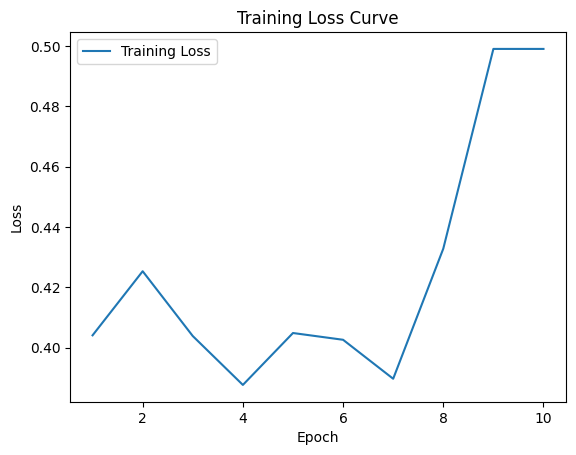

In [31]:
# Plot the loss curve
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

# Save the entire trained model
#torch.save(model, 'fine_tuned_model.pth')


In [33]:
import torch
import numpy as np
from sklearn.metrics import roc_curve

# evaluate model:
model.eval()
with torch.no_grad():
    model.train()
    similarities = []
    labels = []
    for inputs, target in testLoader:
        #print("Inputs:", inputs)
        #print("Target:", target)
        if inputs is None or target is None:
            continue
            
        # Extract audio1 and audio2 from inputs
        audio1 = inputs[:, 0]  
        audio2 = inputs[:, 1]  
        
        # Pass the input tensors to the model
        audio1 = torch.tensor(audio1)
        audio2 = torch.tensor(audio2)
        #print("audio1 shape", audio1.shape)
        
        # Extract embeddings
        audio1 = feature_extractor(audio1, return_tensors="pt", sampling_rate=16000)
        audio1 = audio1.input_values.squeeze(0) 
       
        audio2 = feature_extractor(audio2, return_tensors="pt", sampling_rate=16000)
        audio2 = audio2.input_values.squeeze(0) 
        
        audio1 = audio1.clone().detach().to(device)
        audio2 = audio2.clone().detach().to(device)
        
        # Get embeddings for audio1
        #print("audio1 shape after embedding extraction", audio1.shape)
        outputs_audio1 = model(input_values=audio1)
        embeddings_audio1 = outputs_audio1.embeddings
        embeddings_audio1 = torch.nn.functional.normalize(embeddings_audio1, dim=-1).cpu()
        
        # Get embeddings for audio2
        outputs_audio2 = model(input_values=audio2)
        embeddings_audio2 = outputs_audio2.embeddings
        embeddings_audio2 = torch.nn.functional.normalize(embeddings_audio2, dim=-1).cpu()
        
        # Calculate cosine similarity between embeddings
        similarity = torch.nn.functional.cosine_similarity(embeddings_audio1, embeddings_audio2, dim=-1)
        
#         print("Similarity:", similarity)
#         print("Label:", target)
        
        similarities.extend(similarity.tolist())
        labels.extend(target.tolist())  # Append the tensor itself, not its item

# Convert lists to numpy arrays
similarities = np.array(similarities)
labels = np.array(labels)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(labels, similarities, pos_label=1)

# Find EER
eer_threshold = thresholds[np.argmin(np.abs(fpr - (1 - tpr)))]
eer = (fpr[np.argmin(np.abs(fpr - (1 - tpr)))] + (1 - tpr)[np.argmin(np.abs(fpr - (1 - tpr)))]) / 2

print("Equal Error Rate (EER): {:.2f}%".format(eer * 100))

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/tmp/ipykernel_34/1376838124.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  audio1 = torch.tensor(audio1)
/tmp/ipykernel_34/1376838124.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  audio2 = torch.tensor(audi

Equal Error Rate (EER): 5.00%
